https://www.fleaflicker.com/forums/site-announcements/topics/quantifying-luck-in-head-to-head-fantasy-leagues-13680

In [1]:
import psycopg2
import configparser
import pandas as pd

In [2]:
# get data from sql server
parser = configparser.ConfigParser()
parser.read('database.ini')
params = parser.items('postgresql')
db = {}
for param in params:
    db[param[0]] = param[1]
conn = psycopg2.connect(**db)
cur = conn.cursor()
cur.execute("SELECT * FROM luck;")
df = cur.fetchall()
conn.close()

In [3]:
# wrangle data
df = pd.DataFrame(df, 
    columns= ['Week', 'Nick', 'Mark', 'Sawyer','Caleb', 'Daniel', 'Metch', 'Tonia', 'Dennis']
    ).drop(['Week'], axis = 1)

In [4]:
df.describe()

,Nick,Mark,Sawyer,Caleb,Daniel,Metch,Tonia,Dennis
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,-13.066667,7.800000,-8.600000,7.666667,-7.933333,1.800000,4.666667,7.666667
std,37.208806,35.635456,46.986016,34.864363,41.014748,33.304225,34.574282,26.781301
min,-86.000000,-86.000000,-86.000000,-71.000000,-86.000000,-43.000000,-71.000000,-14.000000
25%,-36.000000,0.000000,-35.500000,-7.000000,-43.000000,-29.000000,-14.000000,-7.000000
50%,-14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.000000,29.000000,7.000000,29.000000,29.000000,21.500000,41.500000,0.000000
max,57.000000,43.000000,71.000000,57.000000,43.000000,71.000000,57.000000,71.000000


In [5]:
import scipy.stats as stats
import matplotlib.pyplot as plt

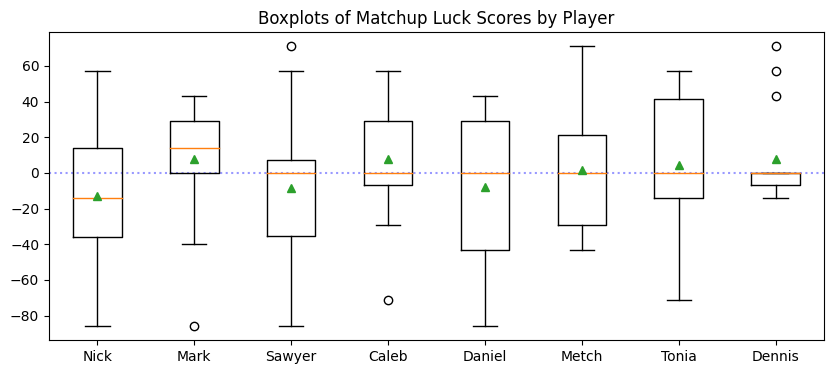

In [6]:
plt.figure(figsize = (10,4))
plt.axhline(y = 0, color = 'blue', linestyle = ':', alpha = 0.4)
plt.boxplot(
    df,
    labels = ['Nick', 'Mark', 'Sawyer','Caleb', 'Daniel', 'Metch', 'Tonia', 'Dennis'],
    showmeans = True
)
plt.title("Boxplots of Matchup Luck Scores by Player")
plt.show()

It is clear that the means are lower for some teams than others. The medians are, perhaps unsurprisingly, almost all 0 (these luck scores are calculated such that within every week the sum of the luck scores is 0). The standard deviations appear to be very large relative to the means. There is not likely a statistically significant difference in the means but lets start with a simple ANOVA to make sure anyways.

In [7]:
stats.f_oneway(
    df['Nick'],
    df['Mark'],
    df['Sawyer'],
    df['Caleb'],
    df['Daniel'],
    df['Metch'],
    df['Tonia'],
    df['Dennis']
    )

F_onewayResult(statistic=0.8125738140940422, pvalue=0.5786681370744882)

Not surprisingly, there is no statistically significant difference in the means. The variance is just too large. 

We can explore this further by looking at Mark's team against the rest of the group. He seems like he was not only luckier on average but was also consistent in that luck -- he has very few negative luck games in the sample. Was he luckier than the rest of the field in a way that tangibly mattered?

In [8]:
df['sum_noMark'] = df.iloc[:, [0,2,3,4,5,6,7]].sum(axis = 1)

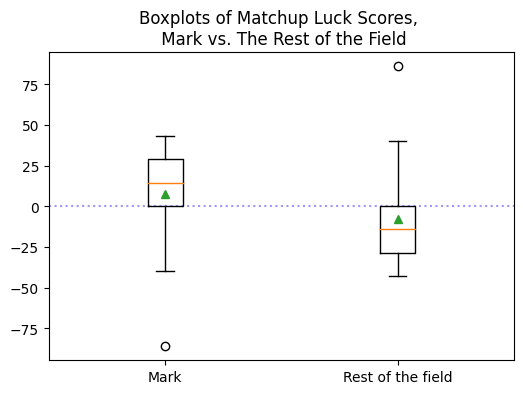

In [9]:
plt.figure(figsize = (6,4))
plt.axhline(y = 0, color = 'blue', linestyle = ':', alpha = 0.4)
plt.boxplot(
    df[['Mark', 'sum_noMark']],
    labels = ['Mark', 'Rest of the field'],
    showmeans = True
)
plt.title("Boxplots of Matchup Luck Scores, \n Mark vs. The Rest of the Field")
plt.show()

Since we have excluded just one team from the rest of the others, the distributions are perfect mirrors of each other (again unsurprising given how the scores are calculated). Maybe we would be better off comparing the best team and the worst team instead of the entire field?

In [10]:
import pymc as pm
import numpy as np
rng = np.random.default_rng(seed=100)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


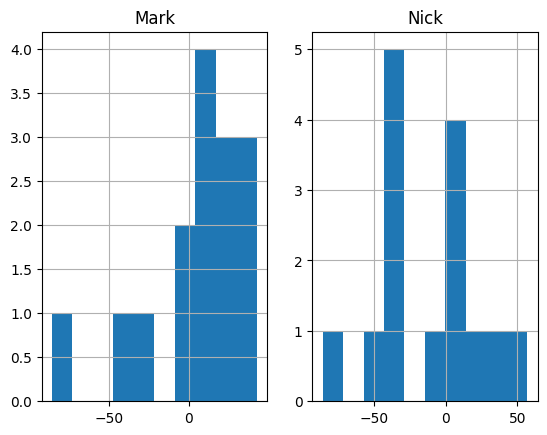

In [11]:
fig, ax = plt.subplots(1,2)
df['Mark'].hist(ax = ax[0])
df['Nick'].hist(ax = ax[1])
ax[0].set_title('Mark')
ax[1].set_title('Nick')
plt.show()

In [12]:
mu_mean_mark = df['Mark'].mean()
mu_mean_nick = df['Nick'].mean()

mu_std_mark = df['Mark'].std()*2
mu_std_nick = df['Nick'].std()*2

with pm.Model() as model:
    mark_mean = pm.Normal("mark_mean", mu = mu_mean_mark, sigma = mu_std_mark)
    nick_mean = pm.Normal("nick_mean",mu = mu_mean_nick, sigma = mu_std_nick)

In [13]:
sig_low = 10
sig_high = 60

with model:
    mark_std = pm.Uniform("mark_std", lower = sig_low, upper = sig_high)
    nick_std = pm.Uniform("nick_std", lower = sig_low, upper = sig_high)

In [14]:
with model:
    v = pm.Exponential("v_minus_one", 1/30.0)

In [15]:
import arviz as az

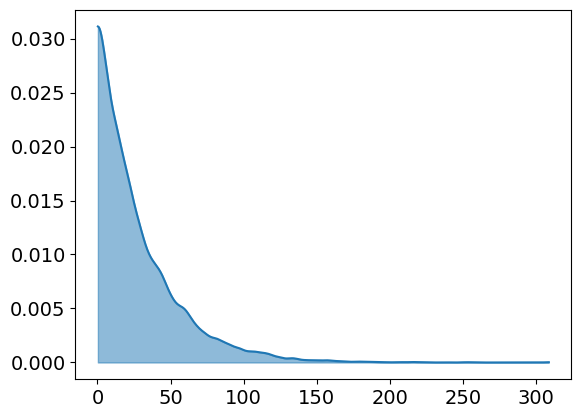

In [16]:
az.plot_kde(rng.exponential(scale=30, size=10000), fill_kwargs={"alpha": 0.5})
plt.show()

In [17]:
with model:
    lam_mark = mark_std**-2
    lam_nick = nick_std**-2

    mark = pm.StudentT("Mark", nu = v, mu = mark_mean, lam = lam_mark, observed = df['Mark'])
    nick = pm.StudentT("Nick", nu = v, mu = nick_mean, lam = lam_nick, observed = df['Nick'])

In [18]:
with model:
    diff_of_means = pm.Deterministic("difference of means", mark_mean - nick_mean)
    diff_of_stds = pm.Deterministic("difference of stds", mark_std - nick_std)
    effect_size = pm.Deterministic(
        "effect size", 
        diff_of_means/np.sqrt((mark_std**2 + nick_std**2)/2)
    )

In [19]:
with model:
    trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mark_mean, nick_mean, mark_std, nick_std, v_minus_one]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 23 seconds.


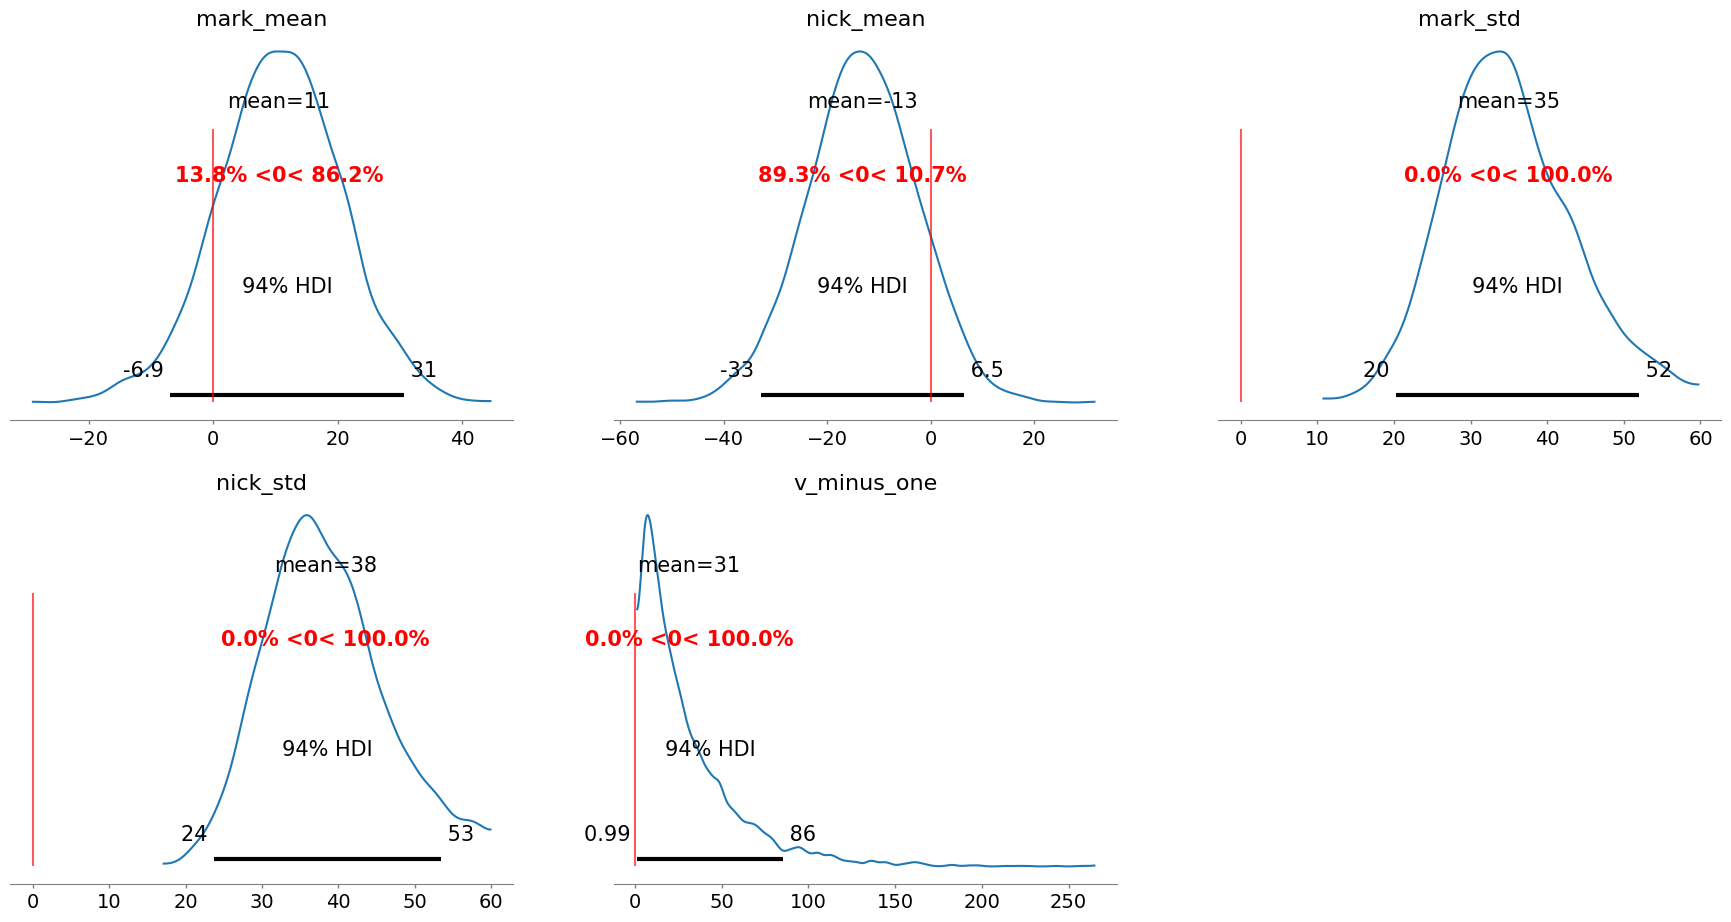

In [20]:
az.plot_posterior(
    trace,
    var_names = ["mark_mean", "nick_mean", "mark_std", "nick_std", "v_minus_one"],
    ref_val=0,
    ref_val_color="red"
)
plt.show()

In [21]:
az.summary(trace, var_names = ["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,23.794,14.453,-3.208,51.147,0.256,0.191,3187.0,2698.0,1.0
difference of stds,-3.368,11.000,-24.534,17.774,0.236,0.220,2197.0,1359.0,1.0
effect size,0.665,0.422,-0.118,1.454,0.008,0.006,2638.0,2935.0,1.0
